Imports and Reading in Data

In [33]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

data = pd.read_csv('data.csv')
data = data.drop(['gameId'], axis=1)
data

,blueWins,blueWardsPlaced,blueWardsDestroyed,blueFirstBlood,blueKills,blueDeaths,blueAssists,blueEliteMonsters,blueDragons,blueHeralds,...,redTowersDestroyed,redTotalGold,redAvgLevel,redTotalExperience,redTotalMinionsKilled,redTotalJungleMinionsKilled,redGoldDiff,redExperienceDiff,redCSPerMin,redGoldPerMin
0,0,28,2,1,9,6,11,0,0,0,...,0,16567,6.8,17047,197,55,-643,8,19.7,1656.7
1,0,12,1,0,5,5,5,0,0,0,...,1,17620,6.8,17438,240,52,2908,1173,24.0,1762.0
2,0,15,0,0,7,11,4,1,1,0,...,0,17285,6.8,17254,203,28,1172,1033,20.3,1728.5
3,0,43,1,0,4,5,5,1,0,1,...,0,16478,7.0,17961,235,47,1321,7,23.5,1647.8
4,0,75,4,0,6,6,6,0,0,0,...,0,17404,7.0,18313,225,67,1004,-230,22.5,1740.4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9874,1,17,2,1,7,4,5,1,1,0,...,0,15246,6.8,16498,229,34,-2519,-2469,22.9,1524.6
9875,1,54,0,0,6,4,8,1,1,0,...,0,15456,7.0,18367,206,56,-782,-888,20.6,1545.6
9876,0,23,1,0,6,7,5,0,0,0,...,0,18319,7.4,19909,261,60,2416,1877,26.1,1831.9
9877,0,14,4,1,2,3,3,1,1,0,...,0,15298,7.2,18314,247,40,839,1085,24.7,1529.8


Heatmap

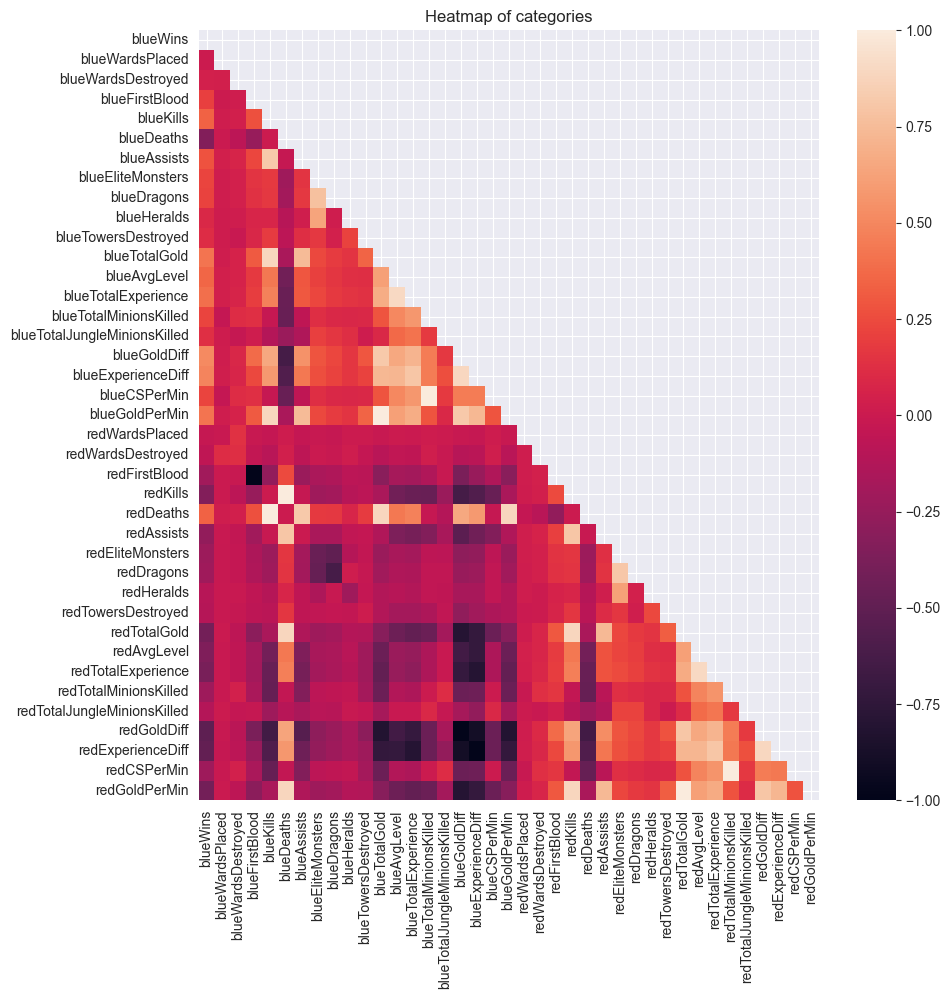

In [44]:
plt.figure(figsize=(10, 10))
corr = data.corr()
mask = np.triu(corr)
sns.heatmap(corr, annot=False, mask=mask)
plt.title('Heatmap of categories')
plt.show()

Processing Data

In [38]:
features = ['blueWardsPlaced', 'blueWardsDestroyed', 'blueFirstBlood', 'blueKills', 'blueDeaths',
            'blueAssists', 'blueEliteMonsters', 'blueDragons', 'blueHeralds', 'blueTowersDestroyed',
            'blueTotalGold', 'blueAvgLevel', 'blueTotalExperience', 'blueTotalMinionsKilled', 
            'blueTotalJungleMinionsKilled', 'blueGoldDiff', 'blueExperienceDiff', 'blueCSPerMin', 
            'blueGoldPerMin',
            'redWardsPlaced', 'redWardsDestroyed', 'redFirstBlood', 'redKills', 'redDeaths',
            'redAssists', 'redEliteMonsters', 'redDragons', 'redHeralds', 'redTowersDestroyed',
            'redTotalGold', 'redAvgLevel', 'redTotalExperience', 'redTotalMinionsKilled', 
            'redTotalJungleMinionsKilled', 'redGoldDiff', 'redExperienceDiff', 'redCSPerMin', 
            'redGoldPerMin']
x_train, x_test, y_train, y_test = train_test_split(data[features].values, data['blueWins'].values, test_size=0.2, random_state=42)

x_train_tensor = torch.tensor(x_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)
x_test_tensor = torch.tensor(x_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)

mean = x_train_tensor.mean(dim=0)
std = x_train_tensor.std(dim=0)
x_train_tensor_normalized = (x_train_tensor - mean) / std
mean = x_test_tensor.mean(dim=0)
std = x_test_tensor.std(dim=0)
x_test_tensor_normalized = (x_test_tensor - mean) / std

dataset = TensorDataset(x_train_tensor_normalized, y_train_tensor)
batch_size = 32
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)


Feedforward Neural Network

In [39]:
class FNN(nn.Module):
    def __init__(self):
        super(FNN, self).__init__()
        self.fc1 = nn.Linear(38, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 1)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)
        
        self.fc = nn.Sequential(self.fc1, self.relu, nn.BatchNorm1d(64), self.dropout,
                                self.fc2, self.relu, nn.BatchNorm1d(32), self.dropout,
                                self.fc3)
        
    def forward(self, x):
        return self.fc(x)

Model Training

In [40]:
model = FNN()
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5)

train_loss_history = []
test_loss_history = []
train_accuracy_history = []
test_accuracy_history = []

epochs = 100
for epoch in range(epochs):
    model.train()
    loss = 0
    accuracy = 0
    avg_loss = 0
    avg_accuracy = 0
    num_batches = 0
    for x_batch, y_batch in dataloader:
        optimizer.zero_grad() 
        
        output = model(x_batch)
            
        loss = criterion(output, y_batch)
        pred = (output.sigmoid() >= 0.5).float()
        accuracy = (pred == y_batch).float().mean()
                
        avg_loss += loss.item()
        avg_accuracy += accuracy.item()
        num_batches += 1
        
        loss.backward()
        optimizer.step()
    model.eval()
    with torch.no_grad():
        pred = ((model(x_test_tensor_normalized)).sigmoid() >= 0.5).float()
    test_accuracy = (pred == y_test_tensor).float().mean().item()
    test_loss = criterion(model(x_test_tensor_normalized), y_test_tensor).item()
        
    avg_loss /= num_batches
    avg_accuracy /= num_batches
    train_loss_history.append(avg_loss)
    test_loss_history.append(test_loss)
    train_accuracy_history.append(avg_accuracy)
    test_accuracy_history.append(test_accuracy)
    
    scheduler.step(test_loss)
    
    print(f'Epoch [{epoch+1}/{epochs}], Loss: Train {avg_loss:.4f} | Test {test_loss:.4f}, Accuracy: Train {avg_accuracy:.4f} | Test {test_accuracy:.4f}')

Epoch [1/100], Loss: Train 0.5804 | Test 0.5299, Accuracy: Train 0.6921 | Test 0.7303
Epoch [2/100], Loss: Train 0.5601 | Test 0.5282, Accuracy: Train 0.7145 | Test 0.7333
Epoch [3/100], Loss: Train 0.5536 | Test 0.5278, Accuracy: Train 0.7243 | Test 0.7313
Epoch [4/100], Loss: Train 0.5477 | Test 0.5250, Accuracy: Train 0.7171 | Test 0.7262
Epoch [5/100], Loss: Train 0.5478 | Test 0.5273, Accuracy: Train 0.7224 | Test 0.7282
Epoch [6/100], Loss: Train 0.5470 | Test 0.5267, Accuracy: Train 0.7191 | Test 0.7262
Epoch [7/100], Loss: Train 0.5483 | Test 0.5275, Accuracy: Train 0.7239 | Test 0.7293
Epoch [8/100], Loss: Train 0.5487 | Test 0.5290, Accuracy: Train 0.7167 | Test 0.7313
Epoch [9/100], Loss: Train 0.5425 | Test 0.5251, Accuracy: Train 0.7262 | Test 0.7298
Epoch [10/100], Loss: Train 0.5450 | Test 0.5304, Accuracy: Train 0.7243 | Test 0.7308
Epoch [11/100], Loss: Train 0.5425 | Test 0.5278, Accuracy: Train 0.7252 | Test 0.7287
Epoch [12/100], Loss: Train 0.5422 | Test 0.5258, Ac

Data Analysis

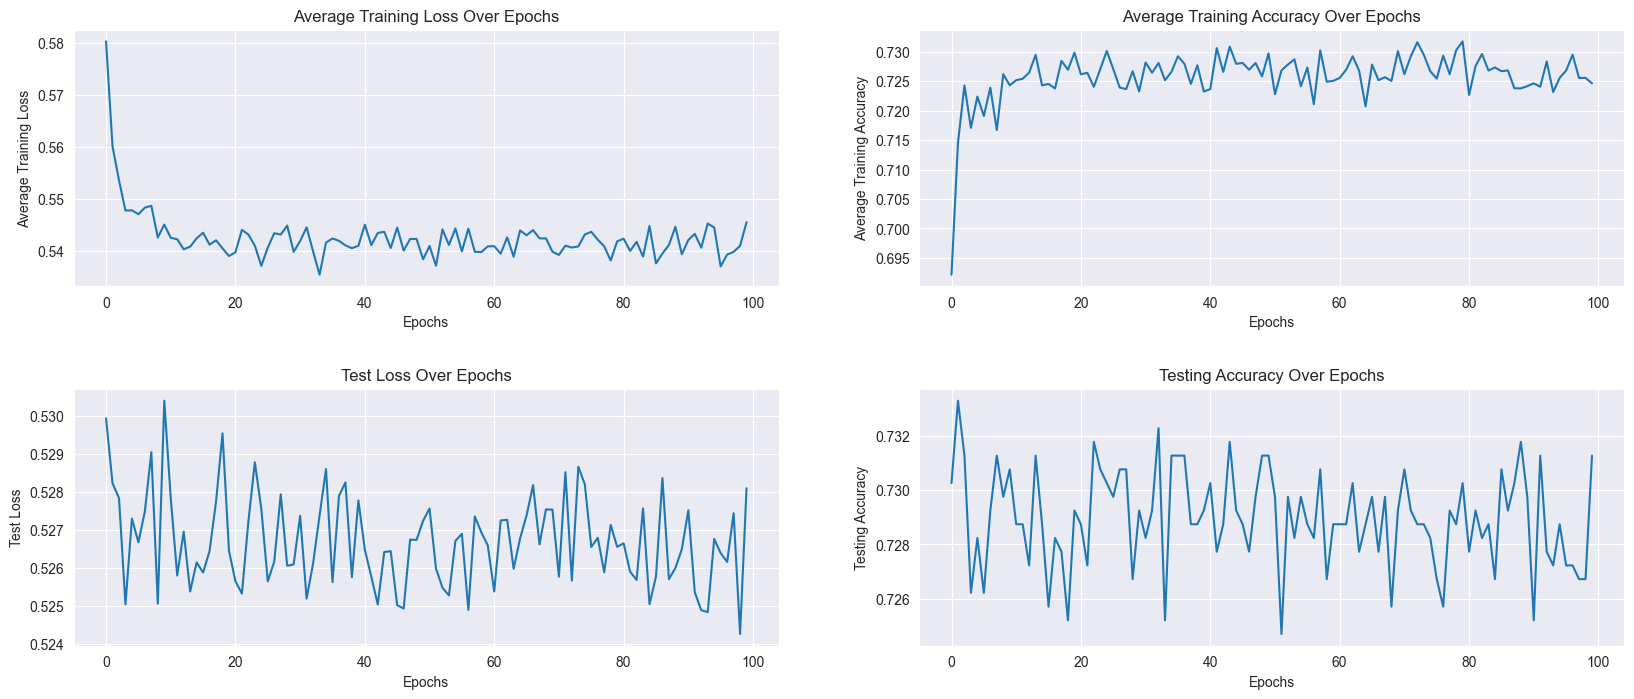

In [41]:
plt.subplots(2, 2, figsize=(20,8))

plt.subplot(2, 2, 1)
sns.lineplot(train_loss_history)
plt.ylabel('Average Training Loss')
plt.xlabel('Epochs')
plt.title('Average Training Loss Over Epochs')

plt.subplot(2, 2, 2)
sns.lineplot(train_accuracy_history)
plt.ylabel('Average Training Accuracy')
plt.xlabel('Epochs')
plt.title('Average Training Accuracy Over Epochs')

plt.subplot(2, 2, 3)
sns.lineplot(test_loss_history)
plt.ylabel('Test Loss')
plt.xlabel('Epochs')
plt.title('Test Loss Over Epochs')

plt.subplot(2, 2, 4)
sns.lineplot(test_accuracy_history)
plt.ylabel('Testing Accuracy')
plt.xlabel('Epochs')
plt.title('Testing Accuracy Over Epochs')

plt.subplots_adjust(hspace=0.4)
plt.show()

Final Accuracy

In [43]:
model.eval()
with torch.no_grad():
    pred = ((model(x_test_tensor_normalized)).sigmoid() >= 0.5).float()
accuracy = (pred == y_test_tensor).float().mean()
print(f'Final Accuracy: {accuracy:.4f}')

Accuracy: 0.7313
